In [1]:
import psycopg2
import pandas as pd
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# loading the env to get database credentials
load_dotenv()

True

In [3]:
# Getting the db credentials from .env file
DB_NAME = os.getenv('DB_NAME')
DB_USER = os.getenv('DB_USER')
DB_PASSWORD  = os.getenv('DB_PASSWORD')
DB_HOST = os.getenv('DB_HOST')

In [4]:
# connecting to the database
conn = psycopg2.connect(
    dbname=DB_NAME,
    user=DB_USER,
    password=DB_PASSWORD,
    host=DB_HOST
)
cur = conn.cursor()

## 1. What is the most common type of crime (based on 'Crm Cd Desc') in each area (based on 'AREA NAME')?

In [5]:
# sql query required
sql_query = '''
WITH crime_counts AS (
select area_name, crm_cd_desc,
count(*) as count_per_area_per_crime,
ROW_NUMBER() OVER (PARTITION BY area_name ORDER BY COUNT(*) DESC) as rn
from la_crime
group by area_name,crm_cd_desc
)

SELECT area_name, crm_cd_desc as most_common_crime, count_per_area_per_crime
from crime_counts
    where rn=1;
'''
df = pd.read_sql_query(sql_query, conn)


C:\Users\niran\AppData\Local\Temp\ipykernel_19336\1596283085.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql_query, conn)


In [6]:
df

,area_name,most_common_crime,count_per_area_per_crime
0,77th Street,VEHICLE - STOLEN,5671
1,Central,BURGLARY FROM VEHICLE,6552
2,Devonshire,VEHICLE - STOLEN,2706
3,Foothill,VEHICLE - STOLEN,3002
4,Harbor,VEHICLE - STOLEN,4033
5,Hollenbeck,VEHICLE - STOLEN,4295
6,Hollywood,BATTERY - SIMPLE ASSAULT,3387
7,Mission,VEHICLE - STOLEN,3861
8,N Hollywood,VEHICLE - STOLEN,3301
9,Newton,VEHICLE - STOLEN,5486


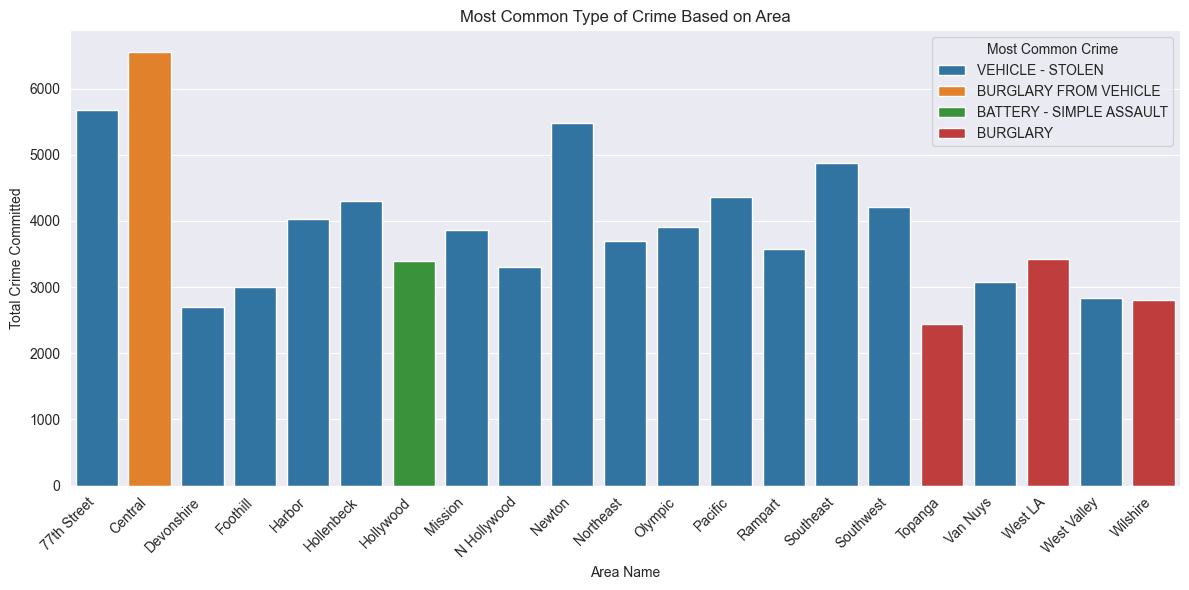

In [7]:
plt.figure(figsize=(12,6))
ax = sns.barplot(df,x="area_name",y="count_per_area_per_crime", hue="most_common_crime",dodge=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.legend(title="Most Common Crime")
plt.ylabel("Total Crime Committed")
plt.xlabel("Area Name")
plt.title("Most Common Type of Crime Based on Area")
plt.tight_layout()
plt.show()

## 2. How does the time of occurrence ('TIME OCC') relate to the type of crime ('Crm Cd Desc')? Are certain crimes more likely at certain times of day?

In [9]:
sql_query = '''
SELECT
crm_cd_desc,
CASE
	WHEN EXTRACT(HOUR FROM time_occ) BETWEEN 0 AND 5 THEN 'Night'
	WHEN EXTRACT(HOUR FROM time_occ) BETWEEN 6 AND 11 THEN 'Morning'
	WHEN EXTRACT(HOUR FROM time_occ) BETWEEN 12 AND 17 THEN 'Afternoon'
	ELSE 'Evening'
END as time_period,
count(*) as crime_count
from la_crime
group by crm_cd_desc, time_period
order by crm_cd_desc, crime_count desc;
'''
df = pd.read_sql_query(sql_query, conn)

C:\Users\niran\AppData\Local\Temp\ipykernel_19336\3748826885.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql_query, conn)


In [10]:
df

,crm_cd_desc,time_period,crime_count
0,ARSON,Night,609
1,ARSON,Evening,534
2,ARSON,Afternoon,432
3,ARSON,Morning,384
4,ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER,Evening,415
...,...,...,...
514,VIOLATION OF TEMPORARY RESTRAINING ORDER,Night,55
515,WEAPONS POSSESSION/BOMBING,Evening,14
516,WEAPONS POSSESSION/BOMBING,Night,6
517,WEAPONS POSSESSION/BOMBING,Afternoon,5


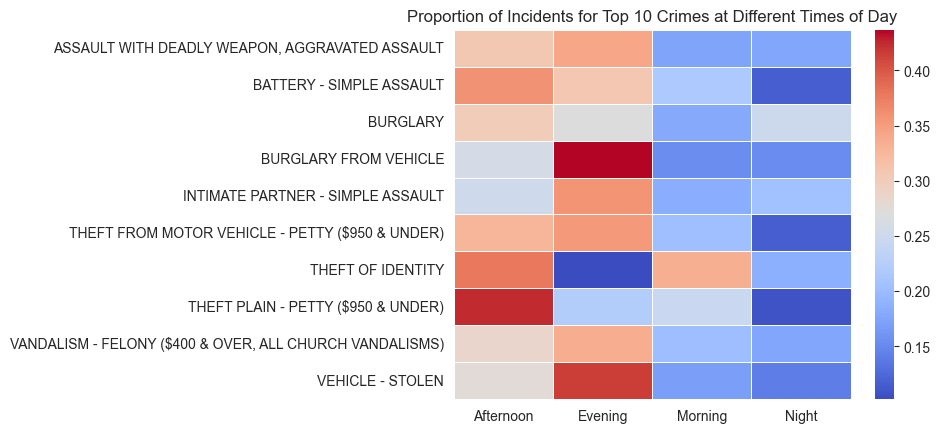

In [11]:

# Calculate total incidents for each crime
df['Total'] = df.groupby('crm_cd_desc')['crime_count'].transform('sum')

# Find the top 10 crimes
top_10_crimes = df.groupby('crm_cd_desc')['Total'].mean().nlargest(10).index

# Filter your dataframe to only include these top 10 crimes, and explicitly create a copy
df_top_10 = df[df['crm_cd_desc'].isin(top_10_crimes)].copy()

# Calculate the proportion of incidents for each time of day and crime type
df_top_10['Proportion'] = df_top_10['crime_count'] / df_top_10['Total']

# Pivot the dataframe to get it in the right format for a heatmap
pivot_top_10 = df_top_10.pivot_table(values='Proportion', index='crm_cd_desc', columns='time_period')

# Plot a heatmap
plt.figure()
sns.heatmap(pivot_top_10, cmap='coolwarm', linewidths=0.5)
plt.xlabel("")
plt.ylabel("")
plt.title('Proportion of Incidents for Top 10 Crimes at Different Times of Day')
plt.show()

## 3. What is the average age ('Vict Age') of victims for each type of crime ('Crm Cd Desc')?

In [12]:
sql_query = '''
SELECT
crm_cd_desc as Crime ,
ROUND(AVG(vict_age)) AS "Average Age"
from la_crime
WHERE vict_age != 0
group by crm_cd_desc
'''
df = pd.read_sql_query(sql_query, conn)

C:\Users\niran\AppData\Local\Temp\ipykernel_19336\3179096894.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql_query, conn)


In [13]:
df

,crime,Average Age
0,ARSON,45.0
1,ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER,32.0
2,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",38.0
3,ATTEMPTED ROBBERY,39.0
4,BATTERY - SIMPLE ASSAULT,41.0
...,...,...
129,"VEHICLE, STOLEN - OTHER (MOTORIZED SCOOTERS, B...",34.0
130,VIOLATION OF COURT ORDER,43.0
131,VIOLATION OF RESTRAINING ORDER,43.0
132,VIOLATION OF TEMPORARY RESTRAINING ORDER,44.0


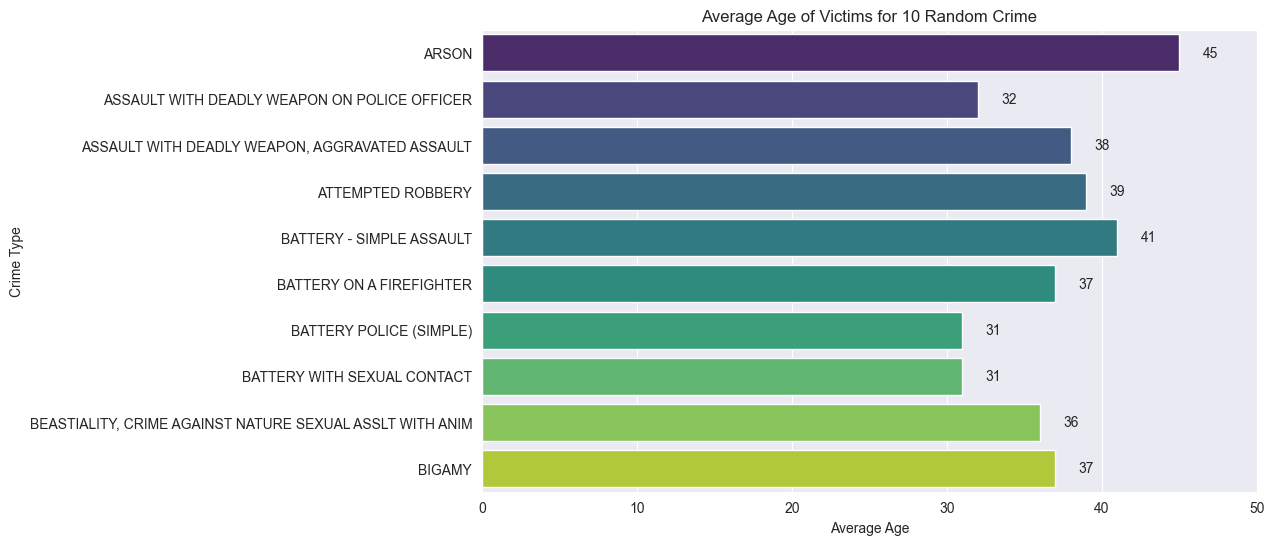

In [36]:


# Select the top 10 crimes
df_random_10 = df.head(10)

# Plot the data
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Average Age", y="crime", data=df_random_10, palette="viridis")
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 1.5,
            p.get_y() + p.get_height()/2,
            '{:1.0f}'.format(width),
            ha="left",
            va="center")
# Increase the x-axis limit
plt.xlim(0, df_random_10["Average Age"].max() + 5)

plt.title('Average Age of Victims for 10 Random Crime')
plt.xlabel('Average Age')
plt.ylabel('Crime Type')
plt.show()

Text(0.5, 1.0, 'Distribution of Average age')

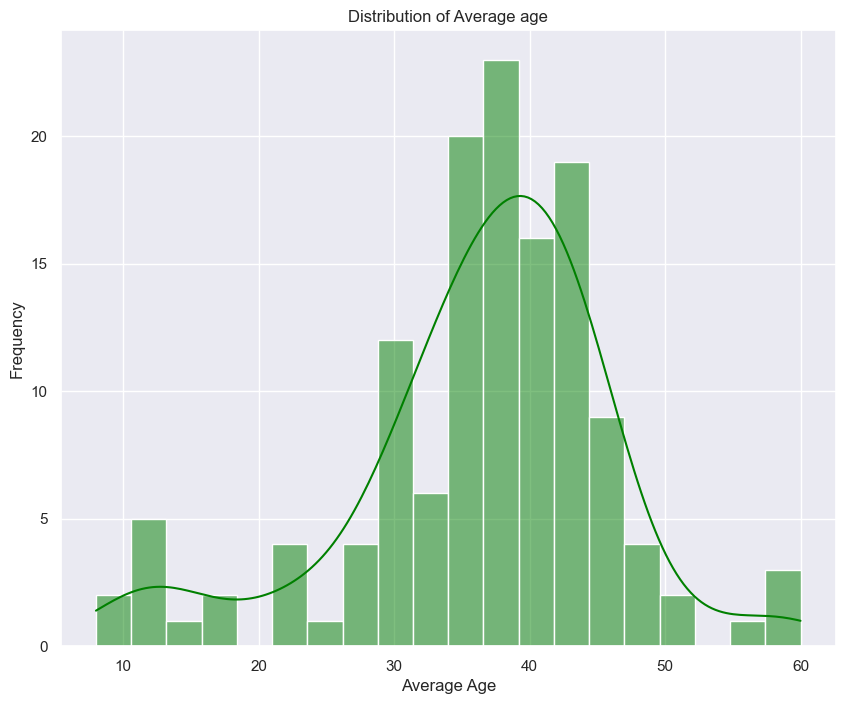

In [50]:
plt.figure(figsize=(10,8))
sns.histplot(data=df, x='Average Age',bins=20, kde=True,  color="green")
plt.xlabel('Average Age')
plt.ylabel('Frequency')
plt.title('Distribution of Average age')


## 4. Are men, women, or non-binary individuals ('Vict Sex') more likely to be victims of certain types of crimes ('Crm Cd Desc')?

In [51]:
sql_query = '''
SELECT
crm_cd_desc,
vict_sex,
count(*) as victim_count
from la_crime
group by crm_cd_desc, vict_sex
order by crm_cd_desc asc, victim_count desc
'''
df = pd.read_sql_query(sql_query, conn)

C:\Users\niran\AppData\Local\Temp\ipykernel_19336\68705869.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql_query, conn)


In [52]:
df

,crm_cd_desc,vict_sex,victim_count
0,ARSON,M,929
1,ARSON,X,561
2,ARSON,F,466
3,ARSON,Unknown,3
4,ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER,M,550
...,...,...,...
456,VIOLATION OF TEMPORARY RESTRAINING ORDER,M,165
457,VIOLATION OF TEMPORARY RESTRAINING ORDER,X,6
458,WEAPONS POSSESSION/BOMBING,X,16
459,WEAPONS POSSESSION/BOMBING,M,9


In [65]:
# total victim for each crime
df['Total'] = df.groupby("crm_cd_desc")["victim_count"].transform("sum")

# finding the most common crime
top_10_crimes = df.groupby('crm_cd_desc')["Total"].mean().nlargest(10).index

# filter dataframe to only include these crimes
df_top_10 = df[df["crm_cd_desc"].isin(top_10_crimes)].copy()

# calculating proportion of gender for the crimes
df_top_10["Gender Proportion"] = df_top_10["victim_count"]/df_top_10["Total"]

# creating pivot table of top 10 crime
pivot_top_10 = df_top_10.pivot_table(values="Gender Proportion", index="crm_cd_desc",columns="vict_sex")

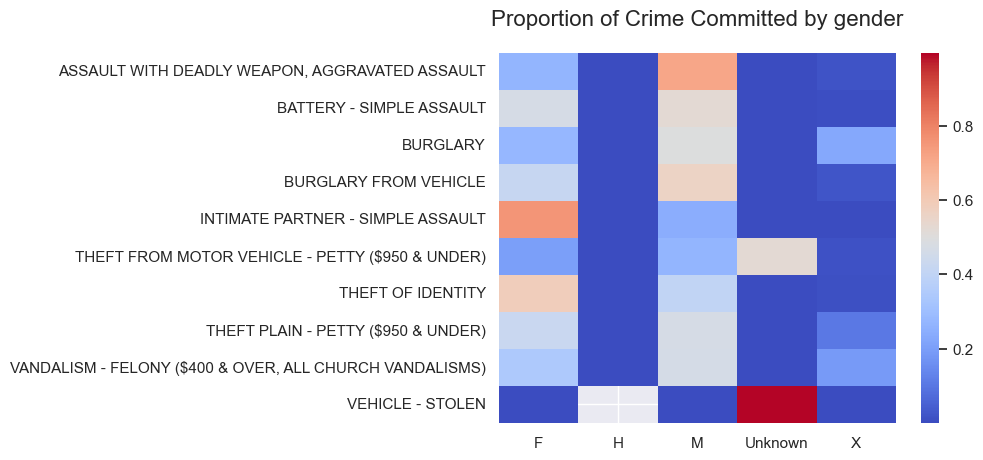

In [77]:
sns.heatmap(pivot_top_10,cmap='coolwarm')
plt.xlabel("")
plt.ylabel("")
plt.title("Proportion of Crime Committed by gender",fontsize=16, pad=20)
plt.show()

## 5. How does crime rate change over the years? Is there an overall increasing or decreasing trend?

In [78]:
sql_query = '''
SELECT
EXTRACT(YEAR FROM date_occ) as Year,
COUNT(*) as Crime_Count,
COUNT(*) / MAX(EXTRACT(DOY FROM date_occ)) as Average_Crimes_Per_Day
FROM la_crime
GROUP BY Year
ORDER BY Year ASC

'''
df = pd.read_sql_query(sql_query, conn)

C:\Users\niran\AppData\Local\Temp\ipykernel_19336\2002526622.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql_query, conn)


In [91]:
# converting year to int from float
df['year'] = df['year'].astype(int)

In [92]:
df

,year,crime_count,average_crimes_per_day
0,2020,199116,544.032787
1,2021,208967,572.512329
2,2022,232874,638.010959
3,2023,67110,588.684211


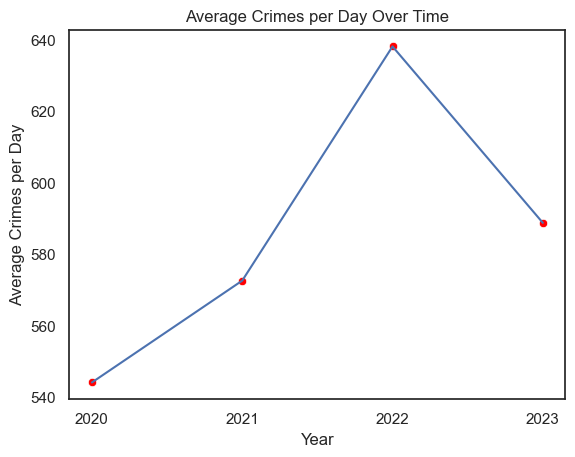

In [97]:

sns.lineplot(data=df,x="year",y='average_crimes_per_day')
sns.scatterplot(data=df, x="year", y="average_crimes_per_day", color='red')
plt.xticks(df['year'])
plt.xlabel("Year")
plt.ylabel("Average Crimes per Day")
plt.title("Average Crimes per Day Over Time")
plt.show()


## 6. How does the rate of crimes differ between different descents ('Vict Descent')?

In [98]:
sql_query = '''
SELECT
vict_descent,
COUNT(*) as Crime_Count
FROM la_crime
group by vict_descent
order by Crime_Count desc

'''
df = pd.read_sql_query(sql_query, conn)

C:\Users\niran\AppData\Local\Temp\ipykernel_19336\229835480.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql_query, conn)


In [99]:
df

,vict_descent,crime_count
0,H,217711
1,W,145709
2,B,102050
3,NA,92639
4,X,66215
5,O,55922
6,A,15430
7,K,3690
8,F,2909
9,C,2596


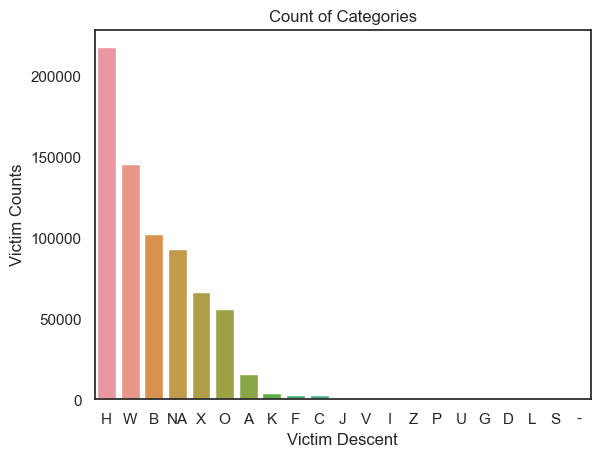

In [101]:
# Create the bar plot
sns.barplot(df, x="vict_descent", y="crime_count")

# Set labels and title
plt.xlabel("Victim Descent")
plt.ylabel("Victim Counts")
plt.title("Count of Categories")

# Display the plot
plt.show()

## 7. What percentage of crimes involve the use of weapons ('Weapon Used Cd' or 'Weapon Desc')?

In [104]:
sql_query = '''
SELECT
weapon_desc,
count(*) as weapon_used_count,
(count(*) / (SELECT count(*) from la_crime)::float)*100 As Weapon_Used_percentage
from la_crime
group by weapon_desc
order by weapon_used_count desc

'''
df = pd.read_sql_query(sql_query, conn)

C:\Users\niran\AppData\Local\Temp\ipykernel_19336\1868382518.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql_query, conn)


In [105]:
df

,weapon_desc,weapon_used_count,weapon_used_percentage
0,Unknown,462133,65.266846
1,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",132140,18.662076
2,UNKNOWN WEAPON/OTHER WEAPON,25296,3.572543
3,VERBAL THREAT,18090,2.554843
4,HAND GUN,15215,2.148808
...,...,...,...
75,MAC-11 SEMIAUTOMATIC ASSAULT WEAPON,3,0.000424
76,MAC-10 SEMIAUTOMATIC ASSAULT WEAPON,2,0.000282
77,HECKLER & KOCH 91 SEMIAUTOMATIC ASSAULT RIFLE,1,0.000141
78,M-14 SEMIAUTOMATIC ASSAULT RIFLE,1,0.000141


In [106]:
df_top_10 = df[:10]

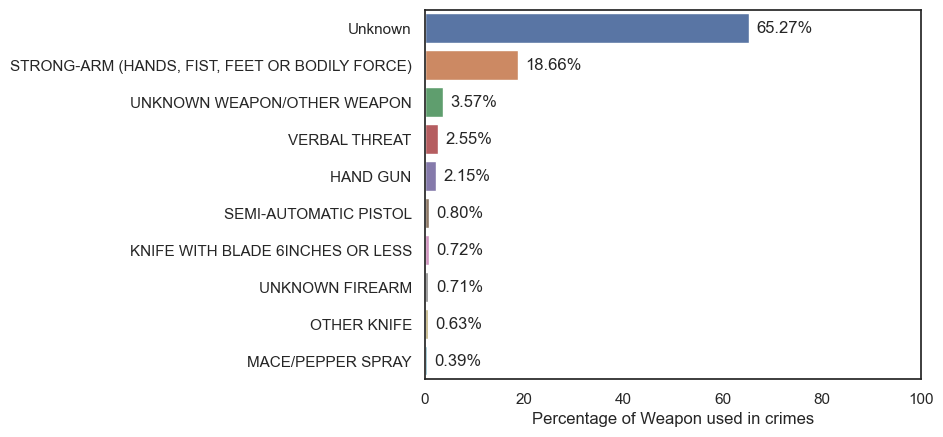

In [120]:
ax = sns.barplot(df_top_10,x='weapon_used_percentage',y="weapon_desc")
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 1.5,
            p.get_y() + p.get_height()/2,
            '{:1.2f}%'.format(width),
            ha="left",
            va="center")
# Increase the x-axis limit
plt.xlim(0, 100)
plt.xlabel("Percentage of Weapon used in crimes")
plt.ylabel("")

plt.show()

## 8. What are the most common locations for crimes to occur (based on 'LOCATION')?

In [131]:
sql_query = '''
SELECT
area_name,
count(*) as crime_count
from la_crime
group by area_name
order by crime_count desc
'''
df = pd.read_sql_query(sql_query, conn)

C:\Users\niran\AppData\Local\Temp\ipykernel_19336\2194912290.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql_query, conn)


In [132]:
df

,area_name,crime_count
0,Central,47439
1,77th Street,44877
2,Pacific,40957
3,Southwest,39763
4,Hollywood,37946
5,Southeast,36376
6,Olympic,35453
7,N Hollywood,35392
8,Newton,35171
9,Wilshire,33467


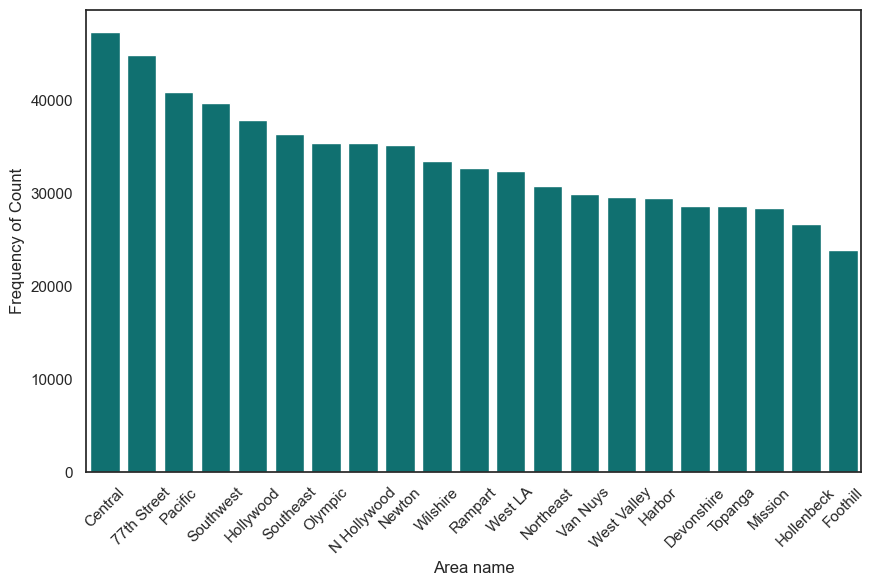

In [144]:
plt.figure(figsize=(10,6))
ax = sns.barplot(df,x='area_name',y="crime_count",color="teal")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45 )
plt.xlabel("Area name")
plt.ylabel("Frequency of Count")
plt.show()

## 9. Are there certain crimes that are increasing or decreasing over time more than others?

In [151]:
sql_query = '''
WITH crime_over_time AS (
  SELECT
    EXTRACT(YEAR FROM date_occ) AS year,
    crm_cd_desc,
    COUNT(*) AS crime_count,
    LAG(COUNT(*)) OVER (PARTITION BY crm_cd_desc ORDER BY EXTRACT(YEAR FROM date_occ)) AS previous_count
  FROM
    la_crime
  GROUP BY
    year, crm_cd_desc
)
SELECT
  year,
  crm_cd_desc,
  crime_count,
  previous_count,
  crime_count - previous_count AS count_change
FROM
  crime_over_time;
'''
df = pd.read_sql_query(sql_query, conn)

C:\Users\niran\AppData\Local\Temp\ipykernel_19336\1349495360.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql_query, conn)


In [152]:
df

,year,crm_cd_desc,crime_count,previous_count,count_change
0,2020.0,ARSON,665,NaN,NaN
1,2021.0,ARSON,627,665.0,-38.0
2,2022.0,ARSON,531,627.0,-96.0
3,2023.0,ARSON,136,531.0,-395.0
4,2020.0,ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER,397,NaN,NaN
...,...,...,...,...,...
508,2023.0,VIOLATION OF TEMPORARY RESTRAINING ORDER,71,236.0,-165.0
509,2020.0,WEAPONS POSSESSION/BOMBING,9,NaN,NaN
510,2021.0,WEAPONS POSSESSION/BOMBING,10,9.0,1.0
511,2022.0,WEAPONS POSSESSION/BOMBING,6,10.0,-4.0


In [171]:
df["Total"] = df.groupby("crm_cd_desc")['crime_count'].transform("sum")

top_5_crimes = df.groupby('crm_cd_desc')["Total"].mean().nlargest(5).index

df_top_5 = df[df["crm_cd_desc"].isin(top_5_crimes)].copy()

df_top_5["year"] = df_top_5["year"].astype(int)
df_top_5["year"] =df_top_5["year"]

In [172]:
df_top_5

,year,crm_cd_desc,crime_count,previous_count,count_change,Total
16,2020,BATTERY - SIMPLE ASSAULT,16327,NaN,NaN,55850
17,2021,BATTERY - SIMPLE ASSAULT,16187,16327.0,-140.0,55850
18,2022,BATTERY - SIMPLE ASSAULT,18041,16187.0,1854.0,55850
19,2023,BATTERY - SIMPLE ASSAULT,5295,18041.0,-12746.0,55850
76,2020,BURGLARY FROM VEHICLE,12707,NaN,NaN,44147
77,2021,BURGLARY FROM VEHICLE,13475,12707.0,768.0,44147
78,2022,BURGLARY FROM VEHICLE,14200,13475.0,725.0,44147
79,2023,BURGLARY FROM VEHICLE,3765,14200.0,-10435.0,44147
430,2020,THEFT OF IDENTITY,8603,NaN,NaN,46061
431,2021,THEFT OF IDENTITY,10921,8603.0,2318.0,46061


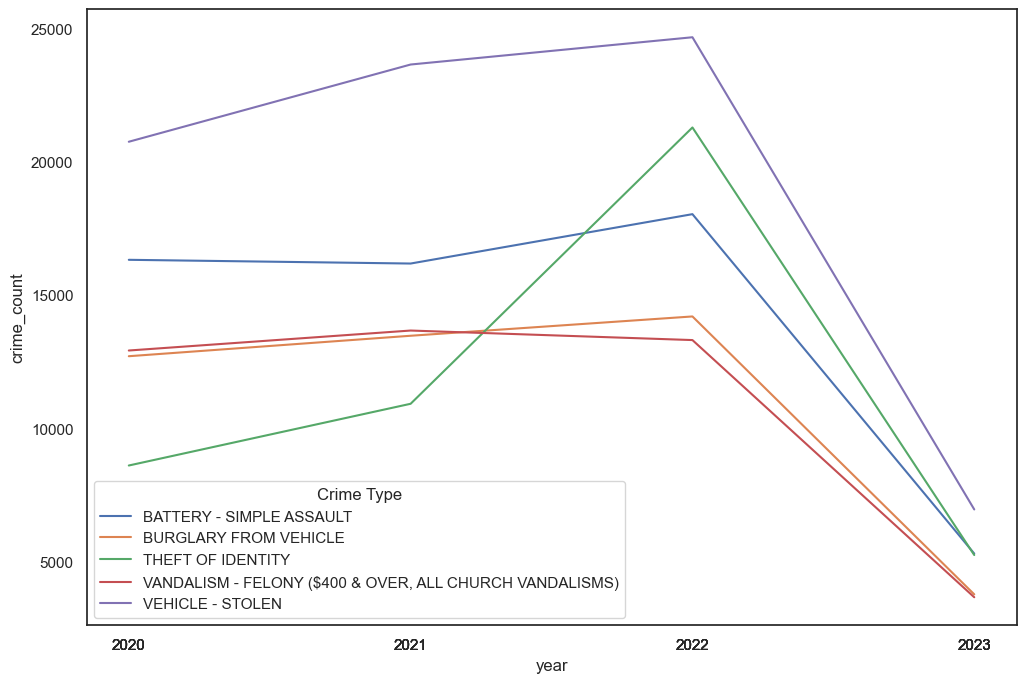

In [179]:
plt.figure(figsize=(12,8))
sns.lineplot(df_top_5,x="year",y="crime_count", hue="crm_cd_desc")
plt.legend(title="Crime Type")
plt.xticks(df_top_5["year"])
plt.show()

## 10. Are certain types of crime more prevalent in certain areas?

In [181]:
sql_query = '''
with total_crimes_by_area as (
Select
	area_name,
	count(*) as total_crime_count
	from la_crime
	group by area_name
),
crime_counts_by_area as (
	SELECT
	area_name,
	crm_cd_desc,
	count(*) as crime_count,
	ROW_NUMBER() OVER (PARTITION BY area_name ORDER BY COUNT(*) desc) as rn
	from la_crime
	group by area_name, crm_cd_desc
)

select
	cc.area_name,
	cc.crm_cd_desc,
	cc.crime_count,
	cc.crime_count * 100.0 / tc.total_crime_count as crime_proportion
from crime_counts_by_area as cc
JOIN
	total_crimes_by_area as tc ON cc.area_name = tc.area_name
where rn <=5
ORDER BY
    cc.area_name,
    cc.crime_count DESC;
'''
df = pd.read_sql_query(sql_query, conn)

C:\Users\niran\AppData\Local\Temp\ipykernel_19336\4015510984.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql_query, conn)


In [182]:
df

,area_name,crm_cd_desc,crime_count,crime_proportion
0,77th Street,VEHICLE - STOLEN,5671,12.636763
1,77th Street,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",4527,10.087573
2,77th Street,THEFT OF IDENTITY,3402,7.580721
3,77th Street,BATTERY - SIMPLE ASSAULT,3372,7.513871
4,77th Street,INTIMATE PARTNER - SIMPLE ASSAULT,3108,6.925597
...,...,...,...,...
100,Wilshire,BURGLARY,2799,8.363463
101,Wilshire,VEHICLE - STOLEN,2772,8.282786
102,Wilshire,BATTERY - SIMPLE ASSAULT,2371,7.084591
103,Wilshire,THEFT PLAIN - PETTY ($950 & UNDER),2246,6.711089


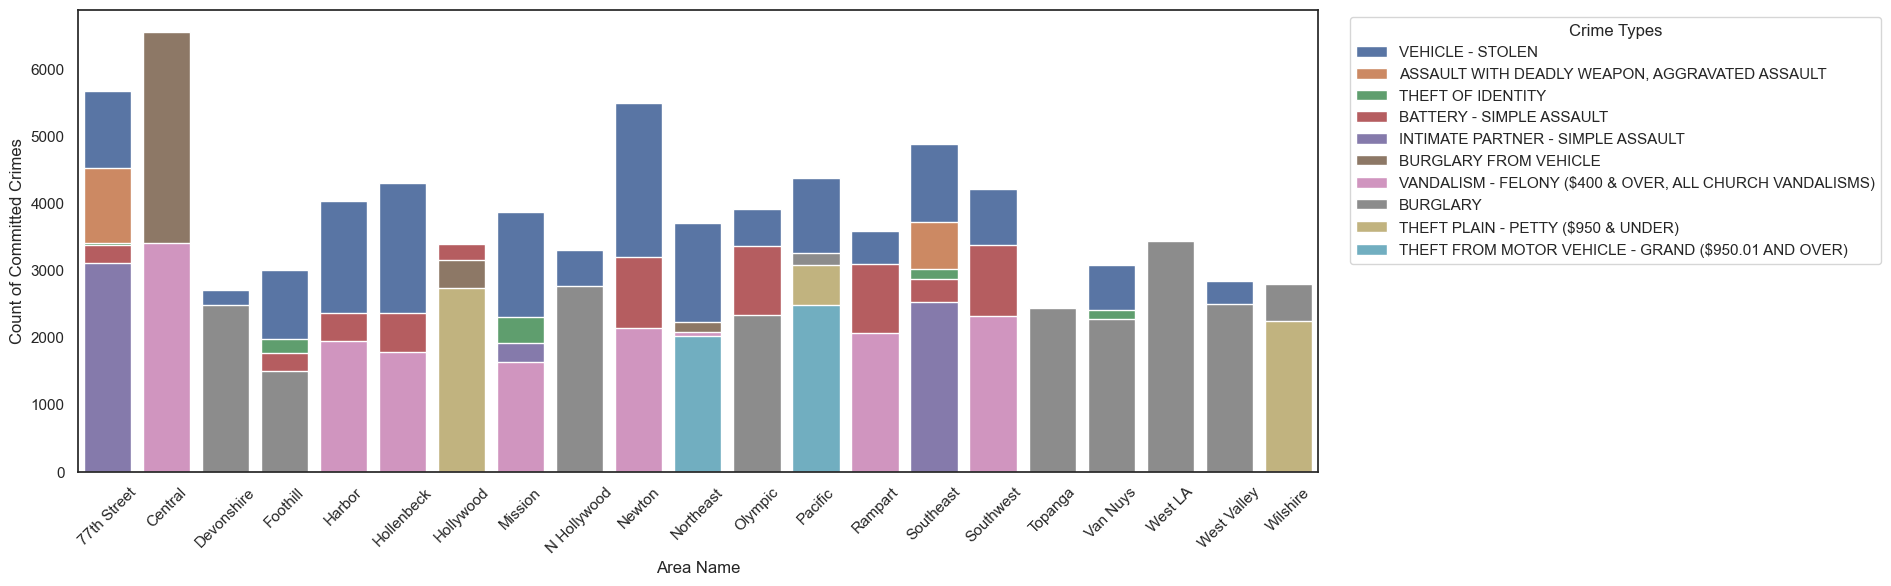

In [197]:
plt.figure(figsize=(16,6))
ax = sns.barplot(df, x="area_name",y="crime_count",hue="crm_cd_desc", dodge=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.legend(title="Crime Types",bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xlabel("Area Name")
plt.ylabel("Count of Committed Crimes")
plt.show()

## 11. Are certain crimes more likely to happen at certain times of the year?

In [202]:
sql_query = '''
SELECT
 crm_cd_desc,
 EXTRACT (MONTH from date_occ) as month_of_occurence,
 count(*) as crime_count
FROM la_crime
group by crm_cd_desc, month_of_occurence
order by crm_cd_desc, crime_count
'''
df = pd.read_sql_query(sql_query, conn)

C:\Users\niran\AppData\Local\Temp\ipykernel_19336\57968265.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(sql_query, conn)


In [203]:
df

,crm_cd_desc,month_of_occurence,crime_count
0,ARSON,12.0,133
1,ARSON,11.0,138
2,ARSON,8.0,154
3,ARSON,6.0,160
4,ARSON,2.0,165
...,...,...,...
1425,WEAPONS POSSESSION/BOMBING,7.0,3
1426,WEAPONS POSSESSION/BOMBING,1.0,3
1427,WEAPONS POSSESSION/BOMBING,8.0,3
1428,WEAPONS POSSESSION/BOMBING,4.0,5


In [210]:
df["total_count"] = df.groupby('crm_cd_desc')['crime_count'].transform(sum)

# finding the top 5 crimes
top_5_crimes = df.groupby('crm_cd_desc')['total_count'].mean().nlargest(5).index

# selecting data for those top 5 crimes
df_top_5 = df[df["crm_cd_desc"].isin(top_5_crimes)].copy()
df_top_5["month_of_occurence"] = df_top_5["month_of_occurence"].astype(int)

In [211]:
df_top_5

,crm_cd_desc,month_of_occurence,crime_count,total_count
48,BATTERY - SIMPLE ASSAULT,12,3900,55850
49,BATTERY - SIMPLE ASSAULT,11,3960,55850
50,BATTERY - SIMPLE ASSAULT,5,4278,55850
51,BATTERY - SIMPLE ASSAULT,6,4353,55850
52,BATTERY - SIMPLE ASSAULT,9,4391,55850
53,BATTERY - SIMPLE ASSAULT,10,4457,55850
54,BATTERY - SIMPLE ASSAULT,8,4624,55850
55,BATTERY - SIMPLE ASSAULT,7,4713,55850
56,BATTERY - SIMPLE ASSAULT,4,5031,55850
57,BATTERY - SIMPLE ASSAULT,2,5161,55850


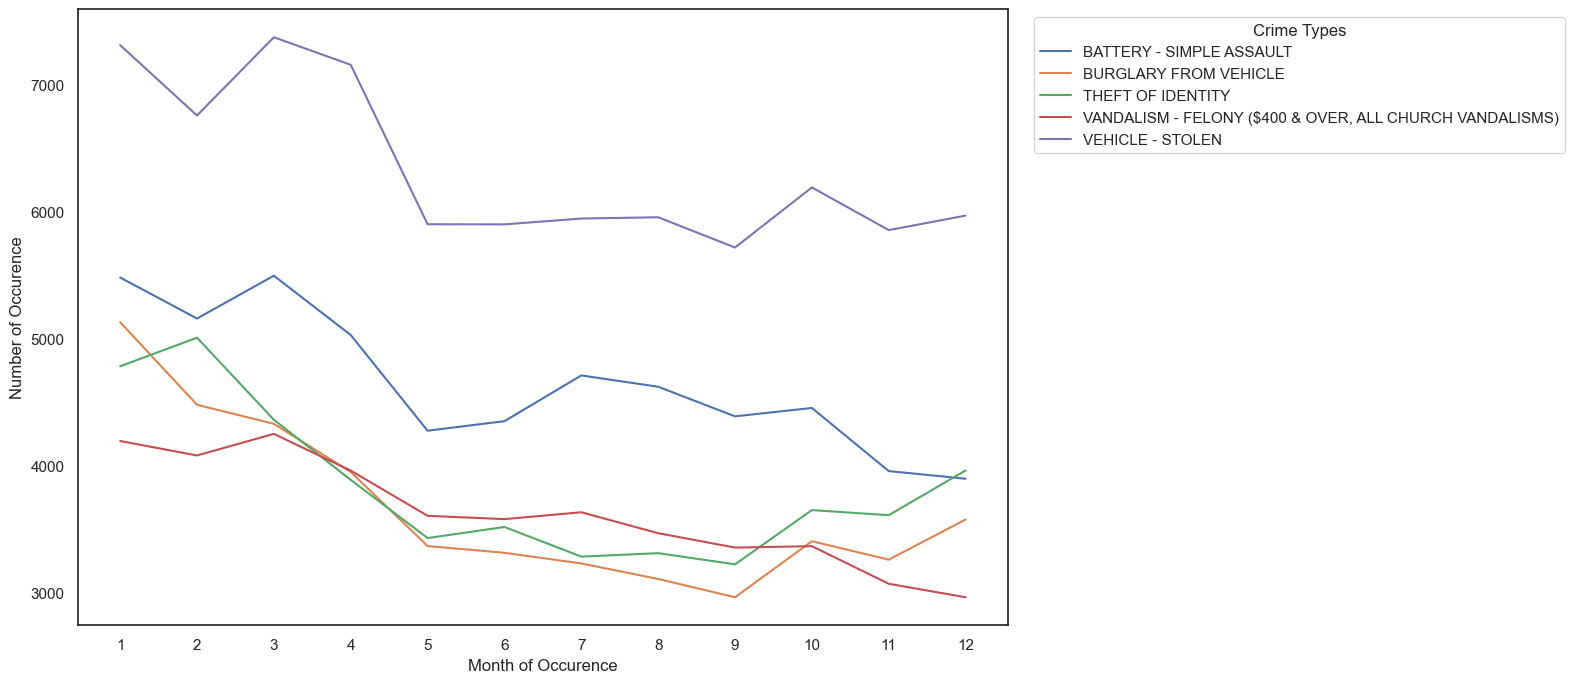

In [223]:
plt.figure(figsize=(12,8))
sns.lineplot(df_top_5,x="month_of_occurence",y="crime_count", hue="crm_cd_desc")
plt.legend(title="Crime Types",bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xlabel("Month of Occurence")
plt.ylabel("Number of Occurence")
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.show()